In [16]:
# Import required libraries
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #Corrects crashing issues in windows

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
# from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize
from numpy.random import randint
# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle

# Set random seed for consistency
# np.random.seed(5)

## Linkage Synthesis Challenge Problem

This challenge problem is focused on synthesizing planar linkage mechanisms such that a specific output curve is traced using the mechanism. For this project you are tasked with synthesizing linkage mechanisms to trace six different output shapes. Further, you are tasked with synthesizing mechanisms such that the total material used for the mechanisms in minimized.

### Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. It will also discuss deliverables and submission instructions. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. **IMPORTANT:** We also provide a **supplementary notebook** with important implementation details and auxiliary information. We highly encourage students to go through this auxiliary notebook after getting oriented with this one. We also provide numerous helper functions in the linkage_utils. We touch on some of these functions in this notebook and go into more details in the supplementary notebook.

### Project Files and Description of Functions Provided:

All files as well as helper functions and the supplementary notebook and further information can be found in the Github repository of this challenge problem:

[Github Repo](https://github.com/ahnobari/MOOMP)


### Mechanism Representation

For this project, we represent planar mechanisms using the following components:
<ol>
    <li><b>Adjacency/Connectivity Matrix: </b>A linkage mechanisms structure can be represented using a matrix of connectivity (C), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.</li>
    <li><b>Node Types: </b>To define the mechanism we must also know which nodes are fixed (or ground nodes). For this purpose we store the list of  ground nodes' numbers.</li>
    <li><b>Motor: </b>To simulate the kinematics of the mechanism we also need to know which linkage is driven (i.e., has the motor attached to it). For this purpose we store the numbers of the two nodes that the driven linkage is connected to.</li>
    <li><b>Initial Positions: </b>Finally, we need to know the initial positions of the nodes that make up the mechanism. For this we store the $x,y$ positions of the nodes in a list. Note that all node positions must be floating point numbers between 0 and 1 (i.e., The initial positions of the mechanism must fit into a box of 1x1).</li>
</ol>

#### Example:
Take the following mechanism (Note that node numbers are started from 0 in our representation):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">

For this example mechanism we have the following Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>):

In [2]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.6],
               [0.6,0.7],
               [0.5,0.75]])

# Motor
# Note: motor[0] is the driving node and motor[1] is being driven around Motor[0]
motor = np.array([0,2])

In [18]:
# this function does a basic check that the linkage works
def check_grashof_condition(a, b, c, d):
    # Calculate the sums of the shortest and longest links
    min_sum = min(a, b, c, d) + max(a, b, c, d)
    other_sum = sum([a, b, c, d]) - min(a, b, c, d) - max(a, b, c, d)
    if min_sum < other_sum:
        return True
    else:
        return False

#this function moves the node a little to try to satisfy the grashof condition. It moves a node on the longer line 10% closer by default
#returns the adjusted
def correct_grashof_violation(x0, Link, move_percentage=0.1):
    
    for i in range(100):
    # Calculate the lengths of the linkages
        lengths = [np.linalg.norm(np.array(x0[p1]) - np.array(x0[p2])) for p1, p2 in Link]
        
        if check_grashof_condition(*lengths):
            return x0
        else:    
            # Find the index of the longest linkage
            print("shortening")
            longest_link_index = lengths.index(max(lengths))
            
            # Find the nodes connected by the longest link
            node1, node2 = Link[longest_link_index]
            
            # Calculate the vector from node1 to node2
            vector_to_node2 = [x0[node2][0] - x0[node1][0], x0[node2][1] - x0[node1][1]]
            
            # Calculate the displacement vector for node2
            displacement_vector = [move_percentage * vector_to_node2[0], move_percentage * vector_to_node2[1]]
            
            # Update the position of node2
            x0[node2] = [x0[node2][0] - displacement_vector[0], x0[node2][1] - displacement_vector[1]]
    
    print("Failed to satisfy Grashof Condition")
    return x0

class Mechanism:
    """Object class for the mechanism. Returns a Grashof mechanism with n nodes. Inputs: n (int) - number of nodes"""
    def __init__(self, n:int, C:object, x0:object, fixed_nodes:object, motor:object, links:object):
        self.n = n
        self.C = C
        self.x0 = x0
        self.fixed_nodes = fixed_nodes
        self.motor = motor
        self.links = links
    def get_C(self):
        return self.C
    def set_C(self, C):
        self.C = C
    def get_x0(self):
        return self.x0
    def set_x0(self, x0):
        self.x0 = x0
    def get_fixed_nodes(self):
        return self.fixed_nodes 
    def set_fixed_nodes(self, fixed_nodes):
        self.fixed_nodes = fixed_nodes    
    def get_motor(self):
        return self.motor 
    def set_motor(self, motor):
        self.motor = motor   
    def get_links(self):
        return self.links 
    def set_links(self, links):
        self.links = links   

def generate_grashof_mechanism():
    """Generate random link lengths within a unit square"""
    C = np.array([[0,1,1,0],\
              [1,0,0,1],\
              [1,0,0,1],\
              [0,1,1,0]], dtype = float)
    fixed_nodes = np.array([0,1])
    motor = np.array([0,2])

    a = np.random.uniform(0.1, 0.5)             # Length of the input link (within [0.1, 0.5])
    b = np.random.uniform(a + 0.1, 1.0 - 0.1)   # Length of the coupler link (within [a + 0.1, 0.9])
    c = np.random.uniform(0.1, 0.5)             # Length of the output link (within [0.1, 0.5])
    d = np.random.uniform(c + 0.1, 1.0 - a)     # Length of the fixed link (within [c + 0.1, 1.0 - a])

    # Calculate the angles for the four-bar Grashof mechanism
    theta2 = np.random.uniform(0.0, 2*np.pi)    # Angle of the coupler link (theta2)
    theta3 = np.random.uniform(0.0, 2*np.pi)    # Angle of the output link (theta3)

    # Check for Grashof condition
    if check_grashof_condition(a, b, c, d):
        # print(a,b,c,d)
        x_init, y_init = 0.0, 0.0
        x0 = np.array([[x_init, y_init], [x_init + d, y_init], [x_init + a * np.cos(theta2), y_init + a * np.sin(theta2)], \
                       [x_init + c * np.cos(theta3), y_init + c * np.sin(theta3)]], dtype = float)
        x_min, y_min = np.min(x0[:,0]), np.min(x0[:,1])
        x0 = x0 - np.array([[x_min, y_min]], dtype = float)
        valid, _, _, _ = solve_mechanism(C, x0, fixed_nodes, motor, device = "cpu", timesteps = 2000)
        if valid:    
            return x0
        else: 
            return generate_grashof_mechanism()
    else:
        return generate_grashof_mechanism()

def generate_5bar_mechanism():
    """Returns a valid 5-bar mechanism."""
    C = np.array([[0,1,1,0,0],\
                  [1,0,0,1,0],\
                  [1,0,0,1,1],\
                  [0,1,1,0,1],\
                  [0,0,1,1,0]], dtype = float)
    x0 = generate_grashof_mechanism()       # x0 of 4-bar linkage
    x0 = np.vstack((x0, np.array([np.random.uniform(0.0, 1.0), np.random.uniform(0.0, 1.0)])))
    fixed_nodes = np.array([0,1])
    motor = np.array([0,2])

    links = np.array([[0,1],\
                     [0,2],\
                     [1,3],\
                     [2,3],\
                     [2,4],\
                     [3,4]], dtype = int)
    mech_5 = Mechanism(5, C, x0, fixed_nodes, motor, links)
    # draw_mechanism(mech_5.C, mech_5.x0, mech_5.fixed_nodes, mech_5.motor)
    return mech_5

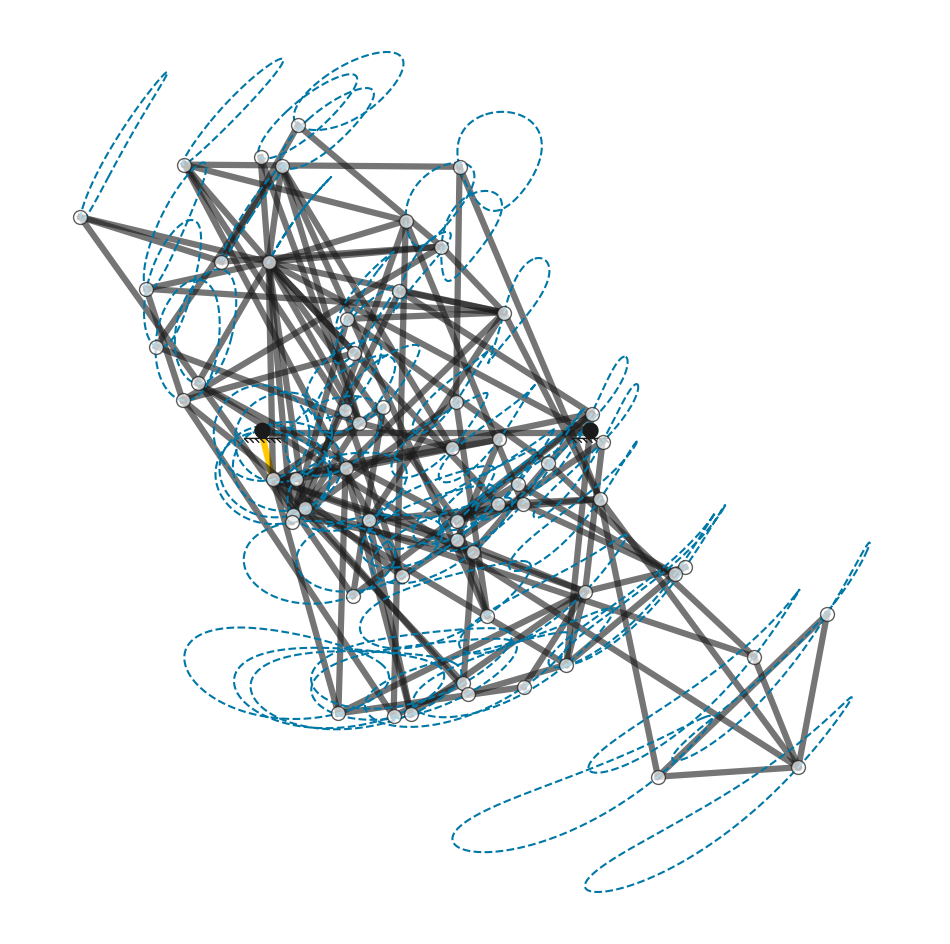

In [64]:
def generate_valid_mechanism(n_nodes:int):
    mech = generate_5bar_mechanism()
    n_add = n_nodes - 5             # Number of nodes to be added

    if n_add < 0:
        raise ValueError('Number of nodes is less than 5. Invalid mechanism.')
    
    for i1 in range(n_add):
        coin_toss = scipy.stats.bernoulli.rvs(p = 0.5)      # Coin toss to decide d_decision or t_decision
        if coin_toss == 0:
            mech = d_decision(mech)
        else:
            mech = t_decision(mech)
        
    return mech

def d_decision(mech:object, hyp:float = 0.5):
    """Function that returns a connectivity matrix and node position of a n+1 linkage. \n Inputs: mech (mechanism object)"""
    C = mech.get_C()
    n = np.shape(C)[0]      # Number of nodes
    x0 = mech.get_x0()
    motor = mech.get_motor()
    fixed_nodes = mech.get_fixed_nodes()
    links = mech.get_links()
    num_links = np.shape(links)[0] - 3
    new_index = np.random.randint(low = 1, high = num_links + 1)
    linkage_nodes = x0[links[new_index + 2],:]              # Coordinates of two nodes in the selected link
    midpoint_link = np.mean(linkage_nodes, axis = 0)
    new_points = midpoint_link + np.array([[np.random.uniform(-hyp, hyp), np.random.uniform(-hyp, hyp)]], dtype = float)        # Coordinate of new node
    C = np.hstack((np.vstack((C, np.zeros((1,n)))), np.zeros((n+1,1))))
    
    # print('Linkage Nodes', linkage_nodes)
    # print('Midpoint', midpoint_link)
    # print('New points', new_points)

    for i1 in range(2):    
        C[links[new_index + 2][i1], n] = 1
        C[n, links[new_index + 2][i1]] = 1

    x0 = np.vstack((x0, new_points))
    links = np.vstack((links, np.array([[links[new_index + 2][0], n], [links[new_index + 2][1], n]])))
    mech.x0, mech.C, mech.links = x0, C, links
    return mech

def t_decision(mech:object, hyp:float = 0.5):
    """Function that returns a connectivity matrix and node position of a n+1 linkage. \n Inputs: mech (mechanism object)"""
    C = mech.get_C()
    n = np.shape(C)[0]      # Number of nodes
    x0 = mech.get_x0()
    motor = mech.get_motor()
    fixed_nodes = mech.get_fixed_nodes()
    links = mech.get_links()
    num_links = np.shape(links)[0] - 3
    new_index = np.random.randint(low = 2, high = num_links + 1)
    linkage_nodes = x0[links[new_index + 2],:]              # Coordinates of two nodes in the selected link
    midpoint_link = np.mean(linkage_nodes, axis = 0)
    new_points = midpoint_link + np.array([[np.random.uniform(-hyp, hyp), np.random.uniform(-hyp, hyp)]], dtype = float)        # Coordinate of new node
    C = np.hstack((np.vstack((C, np.zeros((1,n)))), np.zeros((n+1,1))))
    
    for i1 in range(2):    
        C[links[new_index + 2][i1], n] = 1
        C[n, links[new_index + 2][i1]] = 1
    
    index_del = np.hstack((np.array([0,1]), np.array(links[new_index + 2])))
    n_list = np.delete(np.arange(n), index_del)
    target_n = np.random.choice(n_list, size = 1)
    C[target_n, n] = 1
    C[n, target_n] = 1
    C[links[new_index + 2][0], links[new_index + 2][1]] = 0
    C[links[new_index + 2][1], links[new_index + 2][0]] = 0

    x0 = np.vstack((x0, new_points))
    links = np.vstack((links, np.array([[links[new_index + 2][0], n], [links[new_index + 2][1], n]])))
    links = np.vstack((links, np.array([target_n[0], n])))
    links = np.delete(links, new_index + 2, axis = 0)

    valid, _, _, _ = solve_mechanism(C, x0, fixed_nodes, motor, device = "cpu", timesteps = 2000)
    if valid:
        """Accept solution if mechanism is valid."""
        mech.x0, mech.C, mech.links = x0, C, links
        return mech
    else:
        """Reject solution and reattempt randomizer."""
        return t_decision(mech)

n_nodes = 20
mech = generate_valid_mechanism(n_nodes)
draw_mechanism(mech.C,mech.x0,mech.fixed_nodes,mech.motor)




**Drawing mechanisms:** To visualize this in python we have provided the <code>draw_mechanism(C,x0,fixed_nodes,motor)</code> function to you in the <code>linkage_utils</code> module.

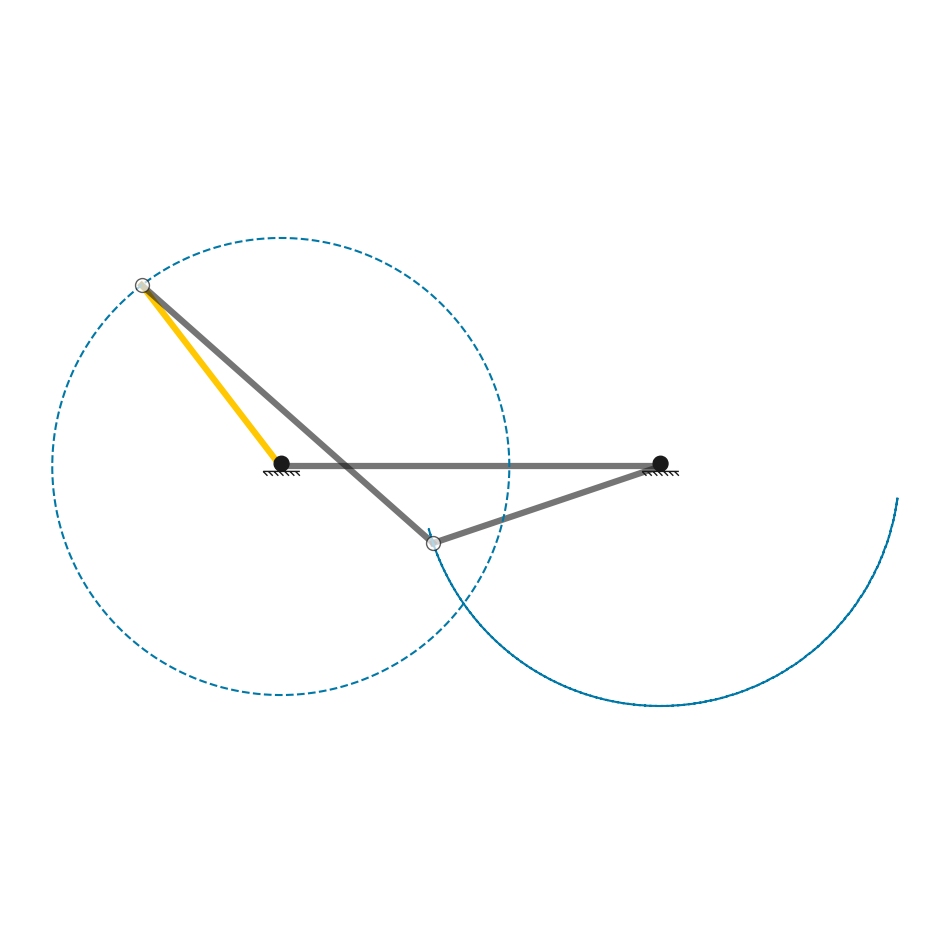

In [154]:
draw_mechanism(C,x0,fixed_nodes,motor)

### Target Curves and Project Objectives

You are tasked with generating mechanisms that are capable of producing curves that mimic a set of target curves as closely as possible. These curves are obtained from randomly generated mechanisms so they are all valid curves that 1 DOF planar mechanisms are capable of producing -- this means that you can exactly match these target curves!

The target curves are provided to you as a point cloud. The curves are actually point clouds on a 500x500 grid. The curves your mechanisms generate are re-oriented then compared to the target curves: We measure the closeness of two point clouds by computing the bi-directional chamfer distance between the two point clouds (more details in the supplementary notebook).

The other objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all links in the mechanism. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Chamfer Distance: </b>Any mechanisms output with a chamfer distance to the target curve larger than 0.2 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 5.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 nodes (i.e., <code>N<=20</code>).</li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.


#### Target Curves

We provide a data folder containing .csv files of the target curves. This folder includes six .csv files with the coordinates of the target curve point clouds in each .csv file starting from 0.csv and ending with 5.csv. Now we will demonstrate how you can load these files into Python.

In [72]:
# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

NameError: name 'target_curves' is not defined

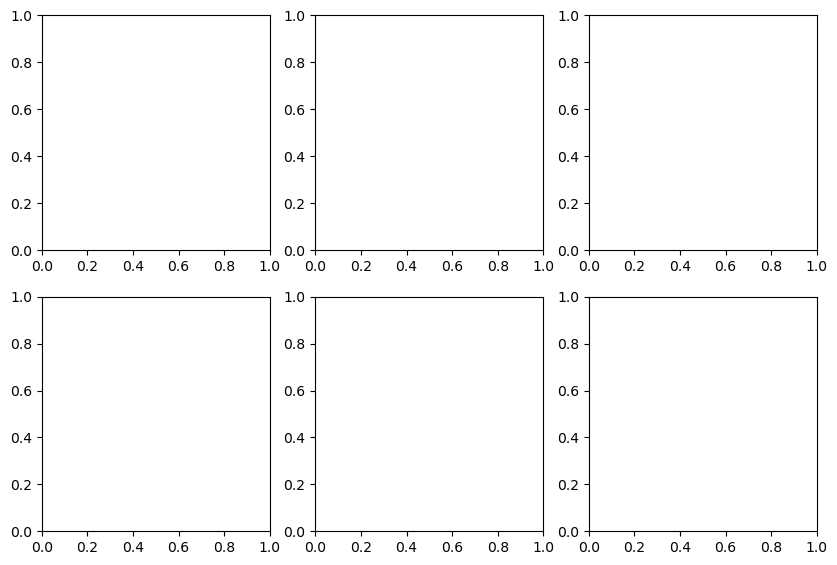

In [131]:
# # Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(10, 6.7))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].scatter(x_coords, y_coords, s=1)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Target {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')


### Submission Format

For your submissions we require sets of mechanisms for each target curve. For this purpose you must obtain 1D representations of each member of the set (for each target curve). To make things easier we have provided the <code>to_final_representation(C,x0,fixed_nodes,motor,target)</code> function to you in the <code>linkage_utils module</code>. We also have provided the <code>from_1D_representation(mechanism)</code> function which returns <code>C,x0,fixed_nodes,motor,target</code> from the 1D representation, essentially reversing the process. As with the other helper functions, the code for this can be found in the provided utils file.

You will create a .csv file with all the mechanisms each in one row of the .csv file, up to 1000, which is the limit we restrict you to. You will submit a .csv file for each target curve, therefore you will have a total of 6 .csv files. We also ask that you submit the 6 .csv files as a zip file. The naming scheme for the submission will be #.csv where you replace # with the number of the target curve starting from 0.csv and up to 5.csv.

Your performance on the targets will be measured based on the hypervolume calculated from the population. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all 6 target curves:

To make this part easier we have also provided a function which will help you make the conversion from python array to .csv for all members of a population. Since we haven't actually generated any mechanisms yet, lets generate some random ones as a placeholder. First let's use the <code>random_generator_ns</code> function we have provided to you to generate 6 random mechanisms (Note: if you pass an <code>n=#</code> parameter to this function and set # to be any number the random mechanism will have that number of nodes). We will add these 6 mechanisms to our example population.

  0%|          | 0/6 [00:00<?, ?it/s]

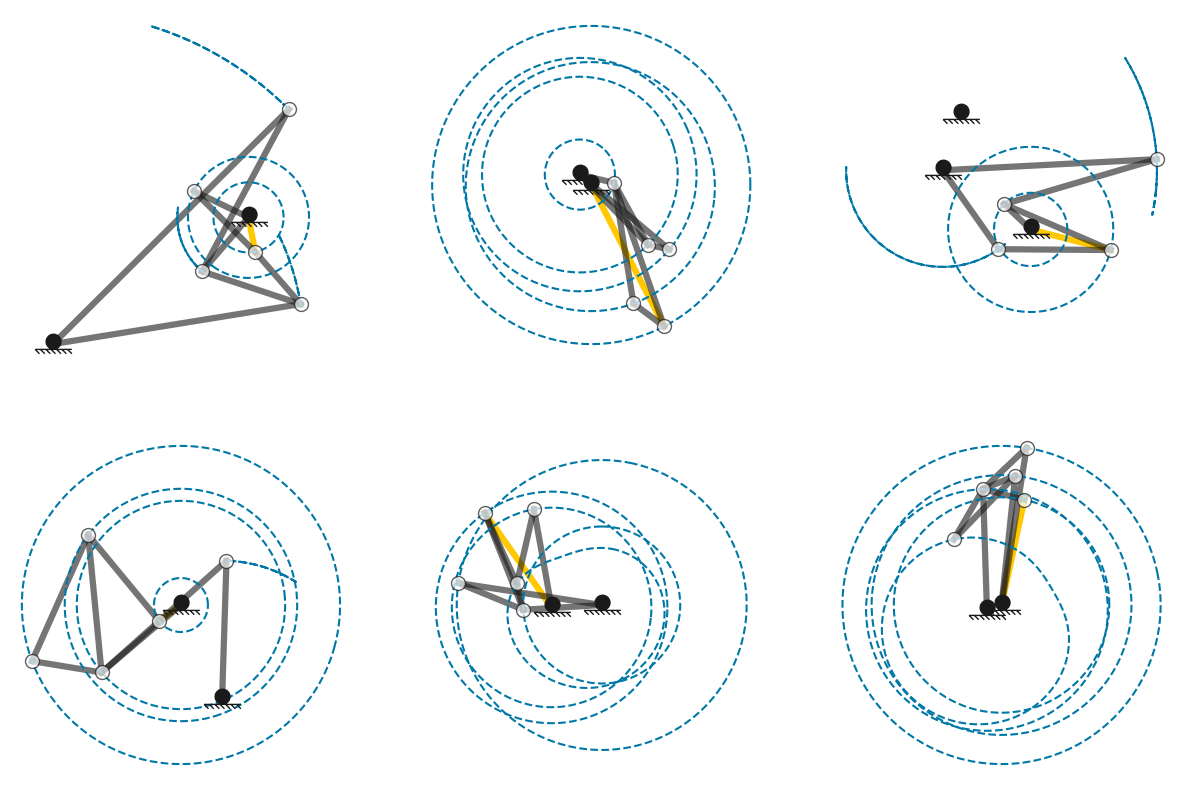

In [12]:
# Initialize population list

population = []

# Create subplots
fig, axs = plt.subplots(2, 3,figsize=(15,10))

# Loop to generate and plot 6 random mechanisms
for i in trange(6):

    # Generate a random mechanism
    C,x0,fixed_nodes,motor = random_generator_ns(n = 7)

    # Plot Mechanism
    draw_mechanism_on_ax(C,x0,fixed_nodes,motor,axs[i//3,i%3])

    # Last node is target
    target = C.shape[0]-1

    # Convert to 1D and add to population
    population.append(to_final_representation(C,x0,fixed_nodes,motor,target))

Now use the provided <code>save_population_csv(file_name,population)</code> to save the list of mechanisms as a .csv file:

In [13]:
save_population_csv('test.csv',population)

You can also use the provided <code>get_population_csv(file_name)</code> to load the list of mechanisms as from a .csv file:

In [14]:
population_reloaded = get_population_csv('test.csv')

Now lets visualize the mechanisms to see if they match the originals:

  0%|          | 0/6 [00:00<?, ?it/s]

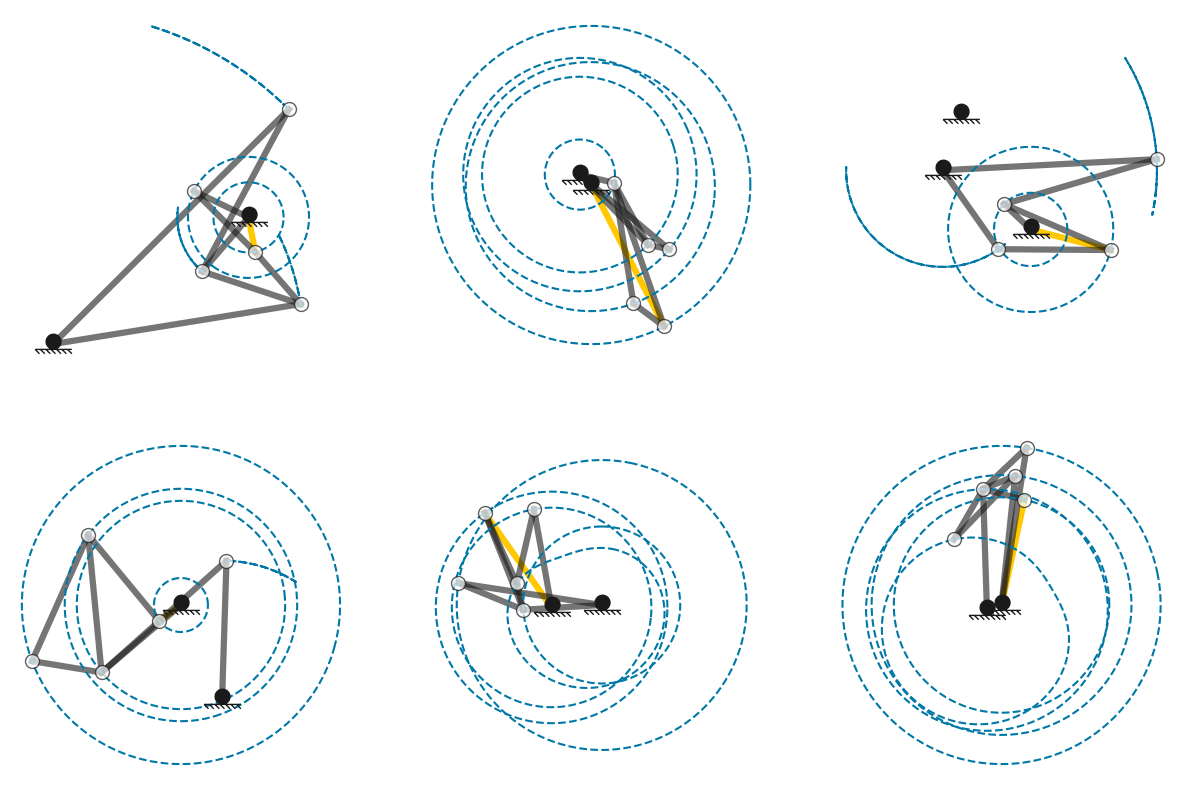

In [15]:
# Set up a 2x3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop to plot 6 mechanisms from the population list
for i in trange(6):
    # Convert 1D representation back to original variables
    C, x0, fixed_nodes, motor, target = from_1D_representation(population[i])

    # Draw the mechanism on the respective subplot
    draw_mechanism_on_ax(C, x0, fixed_nodes, motor, axs[i // 3, i % 3])


### Starter Code: Setting up Multi-Objective Optimization With Constraints Using Pymoo

Now that we have established the details to the project lets set up the problem in Pymoo and run an example. Here we will also discuss how your submissions are going to be evaluated to get your final score.

To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. We already gave you code to create 1D representations! This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. We know the connectivity matrix is symmetric and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix we will only have it come up with the upper triangular half of the matrix (Not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism (<b>The random generator also does this by default!</b>):

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be <code>[1,0]</code>. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/misc/constraints.html?highlight=const)) as less than or equal to zero constraints. We will set the two constraints on chamfer distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (C, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the <code>from_1d_representation</code> function used for submissions. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>fix_mechanism</code>: Takes a potentially invalid mechanism and performs some basic corrections to attempt to fix it. We have provided one trivial check to correct mechanisms that have inadvertantly made node 1 (the driven node) fixed. Expanding this suite of corrections can further assist your algorithm by correcting infeasible designs.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct and repair the mechanism using <code>convert_1D_to_mech</code> and <code>fix_mechanism</code>. Next, we pass our mechanism to the simulator. If the mechanism is locking or over/underdefined, we set the objective scores to infinity. We then normalize, rasterize, calculate the bidirectional chamfer distance to the target, and evaluate the material usage. This will give us our two scoring objectives for this particular mechanism.
    </li>
</ul>

In [17]:
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_point_cloud, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.tpc = target_point_cloud


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target node value
        target = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_nodes = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return target, C, x0, fixed_nodes, motor

    # def convert_mech_to_1D(C,x0,fixed_nodes,motor, target, N):
    #     variables = dict()
    #     for i in range(N):
    #         for j in range(i):
    #             variables["C" + str(j) + "_" + str(i)] = C[i,j]

    #     del variables["C0_1"]

    #     for i in range(2*N):
    #         variables["X0" + str(i)] = x0.flatten()[i]

    #     for i in range(N):
    #         variables["fixed_nodes" + str(i)] = i in fixed_nodes

    #     variables["target"] = target

    #     return variables

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        target, C, x0, fixed_nodes, motor = self.convert_1D_to_mech(x)

        #Call our evaluate function to get validity, CD, and material use
        valid, CD, mat, _ = evaluate_mechanism(C,x0,fixed_nodes, motor, self.tpc, idx=target, device='cpu',timesteps=2000)

        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf, np.Inf]
        else:
            out["F"] = [CD,mat]

            # Set constraints as CD<=0.1 and Material<=10
            # Be careful about modifying these - designs that
            # violate the problem constraints will not be scored.
            out["G"] = [CD - 0.1, mat - 10]




Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 5 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

(-0.024300000000000002, 0.5103, -0.0035000000000000005, 0.07350000000000001)

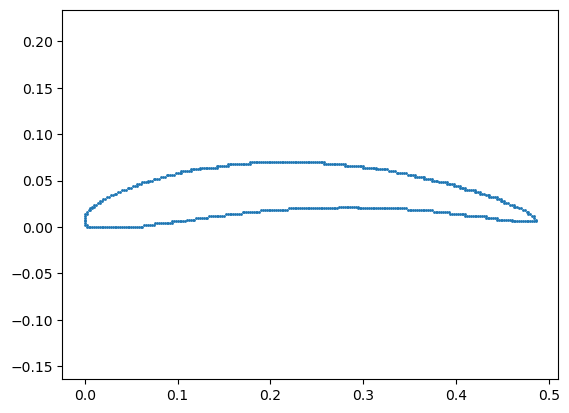

In [18]:
# Get target curve 0 and plot
target_index = 0
target_curve = np.array(target_curves[target_index])
plt.scatter(target_curve[:,0],target_curve[:,1],s=1)
plt.axis('equal')

In [19]:
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,5)


# Set up GA with pop size of 100 -- see pymoo docs for more info on these settings!
algorithm = NSGA2(pop_size=100, sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination())


# Run for 100 generations -- see pymoo docs for more info on these settings!
results = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   verbose=True,
                   save_history=True,
                   seed=0,
                  )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.1997479072 |           INF |             - |             -
     2 |      200 |      1 |  0.1997479072 |           INF |             - |             -
     3 |      300 |      1 |  0.1997479072 |           INF |             - |             -
     4 |      400 |      1 |  0.1997479072 |           INF |             - |             -
     5 |      500 |      1 |  0.1997479072 |           INF |             - |             -
     6 |      600 |      1 |  0.1997479072 |           INF |             - |             -
     7 |      700 |      1 |  0.0648136724 |           INF |             - |             -
     8 |      800 |      1 |  0.0648136724 |           INF |             - |             -
     9 |      900 |      1 |  0.0648136724 |           INF |             - |             -
    10 |     1000 |      1 |  0.0648136724 |           INF |             - |             -

Pymoo automatically saves the optimal set of solutions and their corresponding performance. <code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions). The constraints that we specify in the problem guidelines are used as a reference point for hypervolume calculations which we will use to measure your submissions performance.

Hyper Volume ~ 0.598980


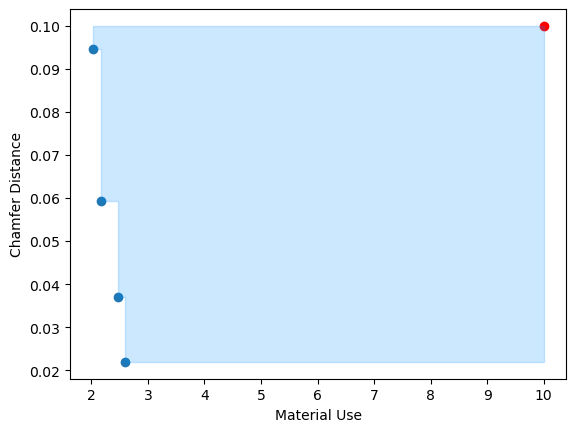

In [20]:
from pymoo.indicators.hv import HV

def plot_HV(F, ref):

    #Plot the designs
    plt.scatter(F[:,1],F[:,0])

    #plot the reference point
    plt.scatter(ref[1],ref[0],color="red")

    #plot labels
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')

    #sort designs and append reference point
    sorted_performance = F[np.argsort(F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[ref]])

    #create "ghost points" for inner corners
    inner_corners = np.stack([sorted_performance[:,0], np.roll(sorted_performance[:,1], -1)]).T

    #Interleave designs and ghost points
    final = np.empty((sorted_performance.shape[0]*2, 2))
    final[::2,:] = sorted_performance
    final[1::2,:] = inner_corners

    #Create filled polygon
    plt.fill(final[:,1],final[:,0],color="#008cff",alpha=0.2)

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.1, 10])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    plot_HV(results.F, ref_point)
else:
    print('Did Not Find Solutions!!')

Now lets plot the results for the best chamfer distance solution

In [22]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,0])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

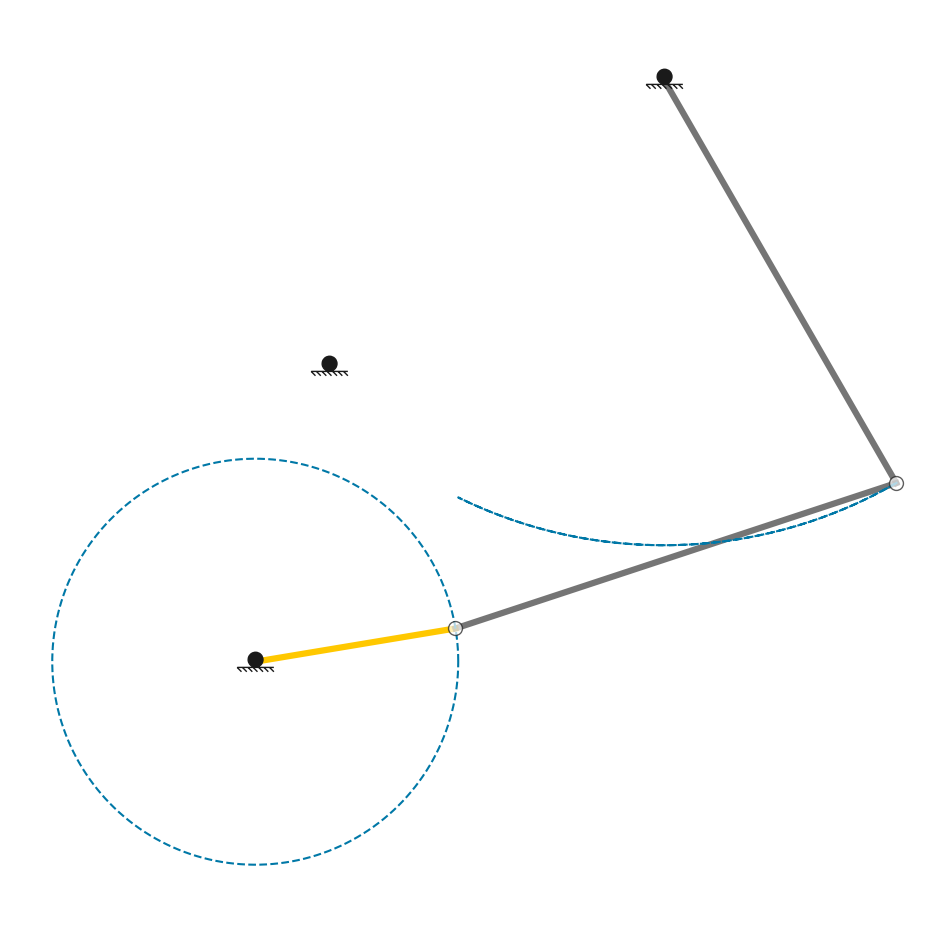

In [23]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)
    # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)

else:
    print('Did Not Find Solutions!!')

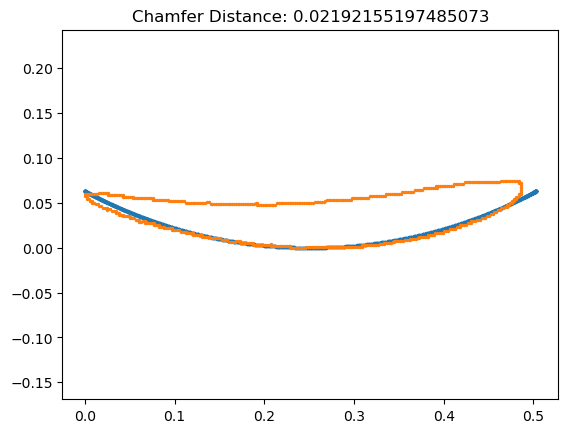

In [24]:
def comparecurves(C, x, fixed_nodes, motor, target, target_pc):
    valid, CD, mat, sol = evaluate_mechanism(C,x,fixed_nodes, motor, target_pc, idx=target,device='cpu',timesteps=2000)
    target_pc = get_oriented(target_pc)
    plt.scatter(sol[:,0],sol[:,1],s=2)
    plt.scatter(target_pc[:,0],target_pc[:,1],s=2)
    plt.title(f"Chamfer Distance: {CD}")
    plt.axis('equal')
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')


Now lets see the solution with the least material use

In [25]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,1])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

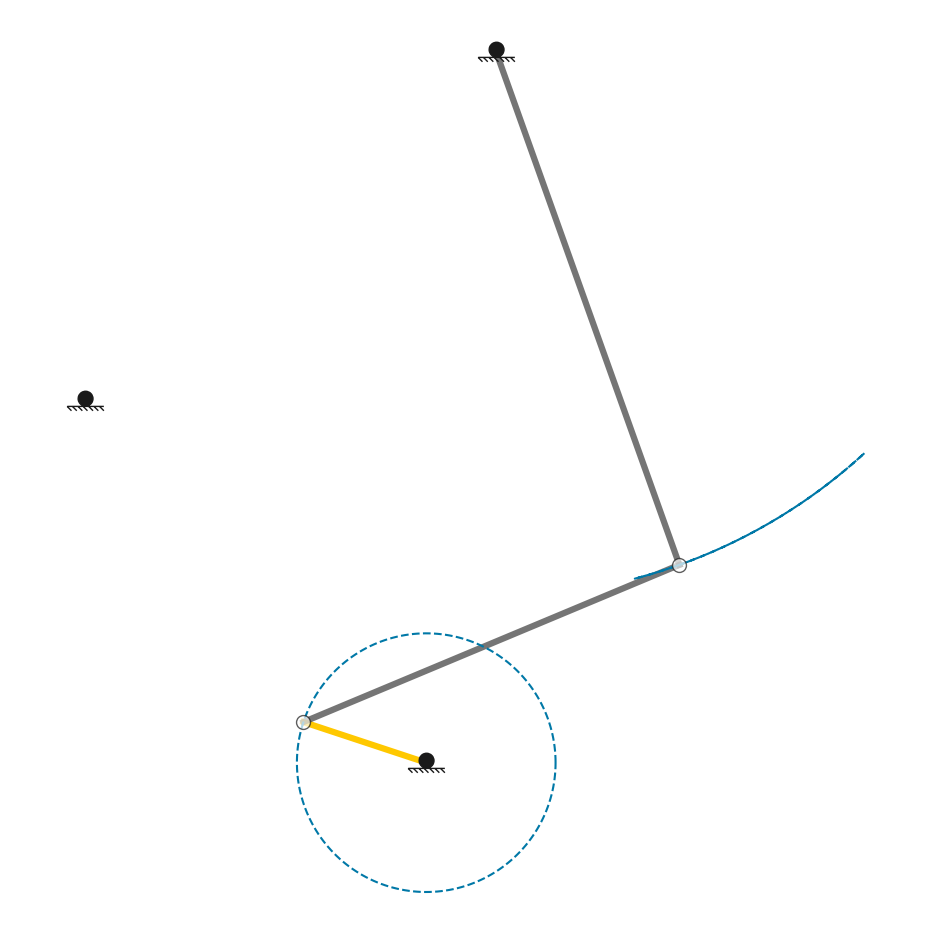

In [26]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)

    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)
else:
    print('Did Not Find Solutions!!')

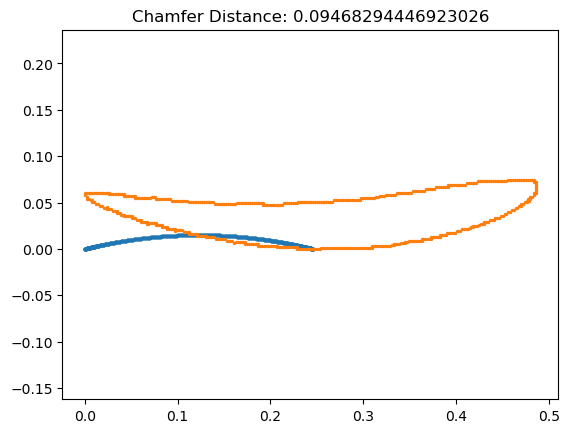

In [27]:
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')

Now lets visualize the pareto front of the last generation

  0%|          | 0/4 [00:00<?, ?it/s]

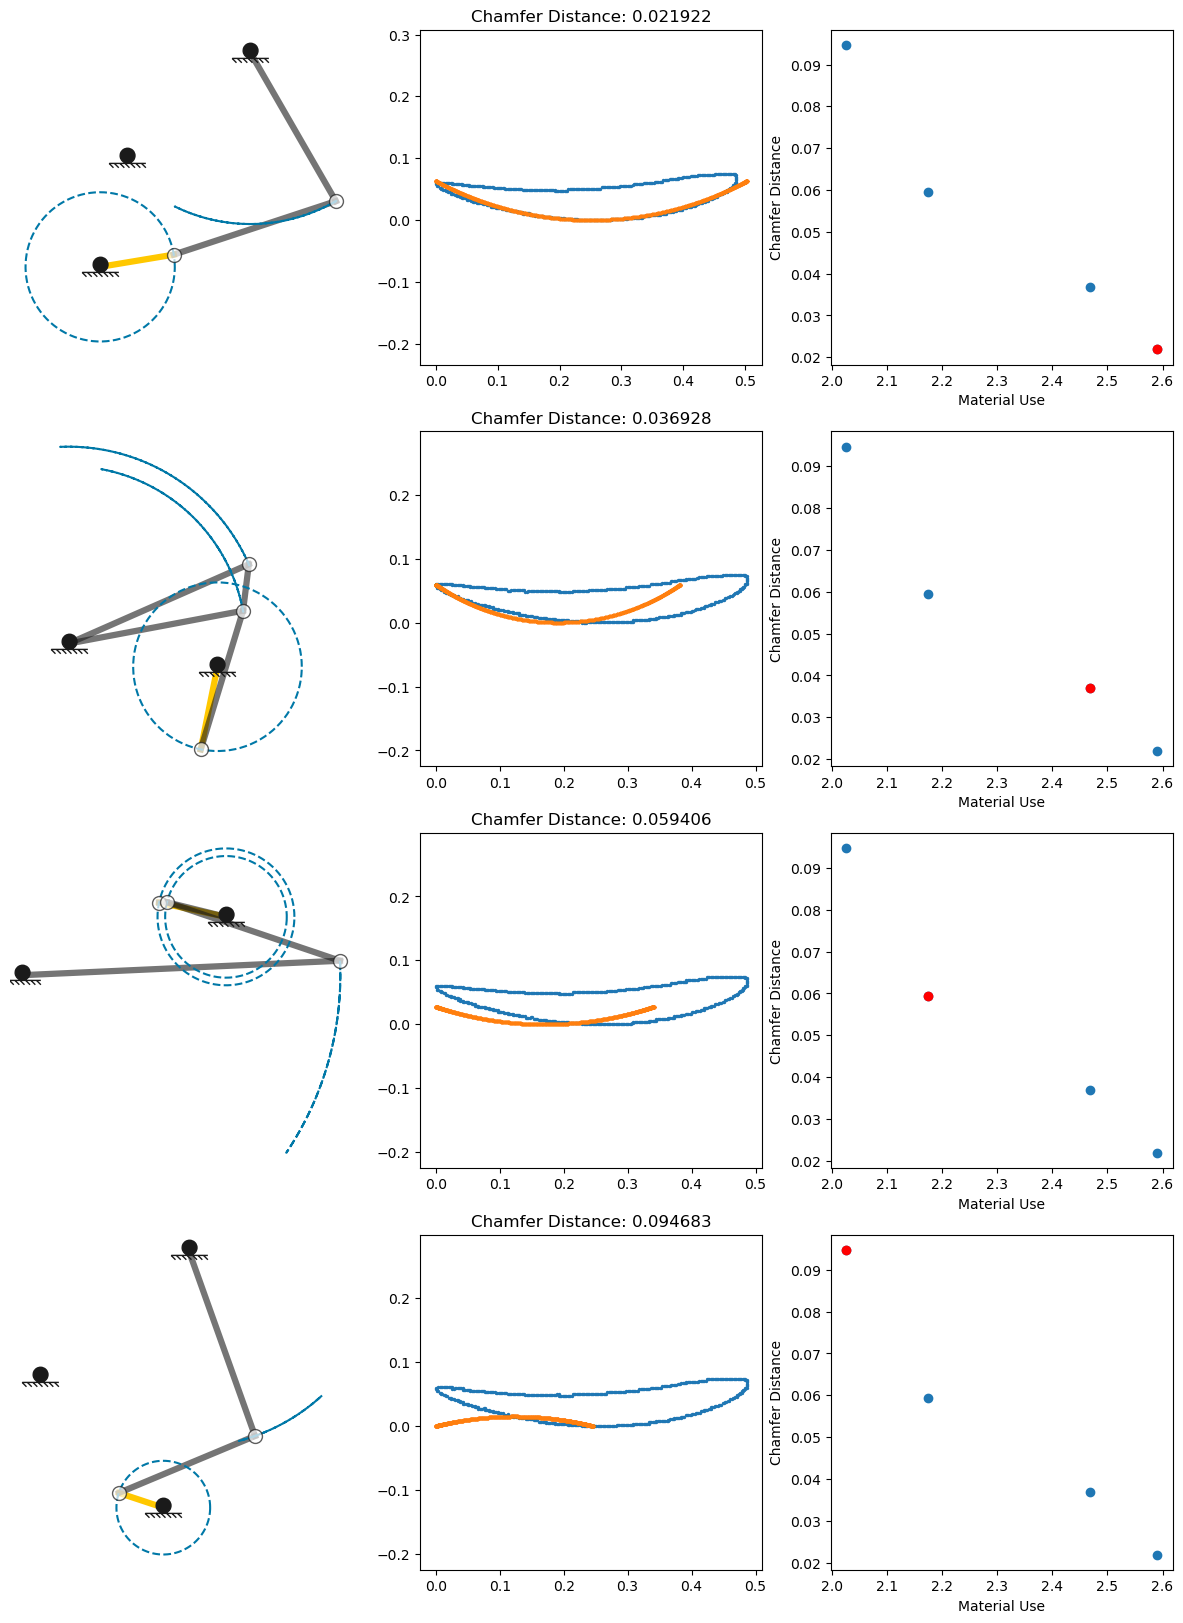

In [28]:
if not results.X is None:
    # first get generalized 1D representation
    mechanisms = []

    for x in results.pop.get("X"):
        target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
        mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))
    # Visualize Pareto Front
    visualize_pareto_front(np.array(mechanisms),results.pop.get("F"),target_curve)
else:
    print('Did Not Find Solutions!!')

At this point lets save our population for submission as a csv.

In [29]:
if not results.X is None:
    save_population_csv('./results/%i.csv'%target_index,mechanisms)
else:
    print('Did Not Find Solutions!!')

To get a score for a submission place all 6 .csv files for in the results folder. Then you can get your overall score by running the following function in the main directory:

In [30]:
evaluate_submission()

  0%|          | 0/6 [00:00<?, ?it/s]

Score Break Down:
Curve 0: 0.598980
Curve 1: 0.507571
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.184425


0.18442517659172944

Alternatively you can run the following command in the terminal (loaded to the main directory of the repo):

In [23]:
!python evaluate.py

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.15it/s]
Score Break Down:
Curve 0: 0.598980
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.099830


### Now Let's Get a Submission Going

Now lets run the process for all the target curves in a loop:

Hyper Volume ~ 0.598980
Hyper Volume ~ 0.507571
Hyper Volume ~ 0.199371
Did Not Find Solutions for Target 3. Trying Seed 2!
Hyper Volume ~ 0.503304
Did Not Find Solutions for Target 4. Trying Seed 2!
Did Not Find Solutions for Target 4. Trying Seed 3!
Did Not Find Solutions for any Seed!!
Did Not Find Solutions for Target 5. Trying Seed 2!
Did Not Find Solutions for Target 5. Trying Seed 3!
Did Not Find Solutions for any Seed!!
--- Execution time: 520.195415019989 seconds ---


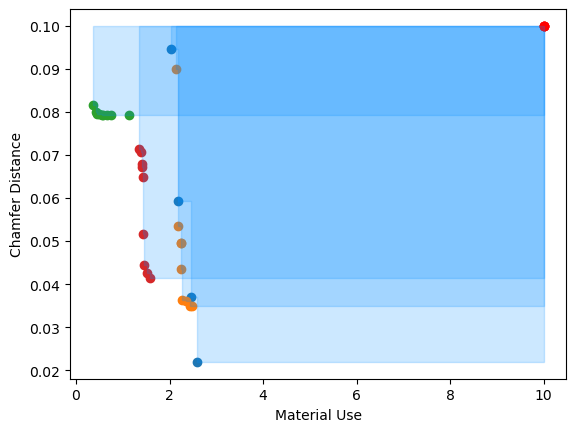

In [31]:
import time
start_time = time.time()

for i,target_curve in enumerate(target_curves):
    # Setup Problem
    problem = mechanism_synthesis_optimization(target_curve,5)

    # Get Algorithm
    algorithm = NSGA2(pop_size=100, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination())

    results.X = None
    count=0
    while results.X is None and count!=2: #Total number of seeds to try

        # Run for 100 generations
        results = minimize(problem,
                           algorithm,
                           ('n_gen', 100),
                           verbose=True,
                           save_history=True,
                           seed=0+count,
                           display=best())
        if results.X is None:
            print('Did Not Find Solutions for Target ' + str(i) + '. Trying Seed ' + str(count+1+1) + '!')
            count+=1


    if results.X is None:
        print('Did Not Find Solutions for any Seed!!')
    else:
        mechanisms = []
        for x in results.X:
            target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
            # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
            mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))

        ref_point = np.array([0.1, 10])
        ind = HV(ref_point)
        hypervolume = ind(results.F)
        print('Hyper Volume ~ %f' %(hypervolume))
        plot_HV(results.F, ref_point)

        save_population_csv('./results/%i.csv'%i,mechanisms)
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

Now let's see how we did:

In [32]:
evaluate_submission()

  0%|          | 0/6 [00:00<?, ?it/s]

Score Break Down:
Curve 0: 0.598980
Curve 1: 0.507571
Curve 2: 0.199371
Curve 3: 0.503304
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.301538


0.3015376140102373

### Extra Material and Challenges With the Current Implemenation

#### Some Important Notes:

<ul>
    <li><b>Random Seeds: </b>If you plan to run things in the notebook please do not forget to remove the random seeds from the code we set the seeds so that the results of the code do not change when you run them again, and you would obviously have better results if you randomize differently every time.</li>
    <li><b>Colab vs Local: </b>If you do plan to use Google Colab for your work remember to download any files you save and the changes to the notebook because every time Google Colab ends the runtime (or it times out) it deletes all files and progress. So <font color="red"><b>BE CAREFUL!</b></font></li> It is generally recommended that you work locally.
</ul>

#### Problems With The Current Implementation:

The current implementation has a few problems (your task is to improve upon this). The first is that the method cannot handle very large sizes of mechanisms and it struggles to find mechanisms that are not locking or under/over defined. Lets see the algorithm try to make mechanisms of size 12. To give it a chance lets run it for 1000 generations:

In [33]:
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,12)

# Get Algorithm
algorithm = NSGA2(pop_size=50, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination())

# Run for 1000 generations
results = minimize(problem,
                   algorithm,
                   ('n_gen', 1000),
                   verbose=True,
                   save_history=True,
                   seed=0)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |           INF |           INF |             - |             -
     2 |      100 |      1 |           INF |           INF |             - |             -
     3 |      150 |      1 |           INF |           INF |             - |             -
     4 |      200 |      1 |           INF |           INF |             - |             -
     5 |      250 |      1 |           INF |           INF |             - |             -
     6 |      300 |      1 |           INF |           INF |             - |             -
     7 |      350 |      1 |           INF |           INF |             - |             -
     8 |      400 |      1 |           INF |           INF |             - |             -
     9 |      450 |      1 |           INF |           INF |             - |             -
    10 |      500 |      1 |           INF |           INF |             - |             -

As you can see it can't get out of the infeasable region. What can we do to fix this problem for larger mechanisms??

Since we know that our mechanism has one degree of freedom, does the current way we have represented our mechanism really the most efficient way to do this? Does the current Mutation/Crossover/Initialization make sense?  Is Genetic Algorthim really the best way to do this? What are the ways you can improve this method?

Understanding evolutionary design of linkages is key to developing better methods for this process. Look at :


<font size="3"><b>Lipson, H. (2008). Evolutionary synthesis of kinematic mechanisms. Artificial Intelligence for Engineering Design, Analysis and Manufacturing, 22(3), 195-205. </b></font> [Online PDF](https://www.cambridge.org/core/journals/ai-edam/article/evolutionary-synthesis-of-kinematic-mechanisms/6DF594784096ECD1C66E9F8CB9AAB0AE)

<font size="3"><b>Bacher, M., Coros, S., Thomaszewski, B. (2015). LinkEdit: interactive linkage editing using symbolic kinematics. ACM Transactions on Graphics (TOG), 34(4), 99.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://dl.acm.org/doi/10.1145/2766985)

Other references:

<font size="2">Deshpande, Shrinath, en Anurag Purwar. A Machine Learning Approach to Kinematic Synthesis of Defect-Free Planar Four-Bar Linkages. Vol 5B: 42nd Mechanisms and Robotics Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85578)


<font size="2">Vermeer, Kaz, Reinier Kuppens, en Justus Herder. Kinematic Synthesis Using Reinforcement Learning. Vol 2A: 44th Design Automation Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85529)

#Appendix

## Extra Information about Mechanism Representation For Submissions

we have made all the functions and examples provided to you based around the representation of the mechanism discussed prior. However, to allow for students to work on different platforms and programming languages we have come up with a different representation which you will use to submit your results. Don't worry: we have also included functions within python to convert the previous representation into this representation.

For the submission we use the same basic 4 components to define the representation of the mechanism, however we flatten all matrices and arrays into a single dimensional array. Further, we also require you to specify the target node (The node which has the desirable trace) The format of this representation is as follows:

<ol>
    <li><b>Number of Nodes:</b> The number of nodes in the mechanism will go at the start of the array. See figure below.</li>
    <li><b>Adjacency/Connectivity Matrix: </b> Each row of the matrix will placed after the previous in the same order. See figure below.</li>
    <li><b>Node Types: </b>Instead of a list of the fixed nodes we will have N elements after the adjacency array which reflect the type of each node (1 if ground and 0 if ordinary node). See figure below.</li>
    <li><b>Initial Positions: </b> Similar to adjacency matrix, this time the two positions of each node will be placed right after the previous node. See figure below.</li>
    <li><b>Motor: </b>Similar what we had before just appended to the rest of the representation. See figure below.</li>
    <li><b>Target: </b>The number of the node to be assessed as a single number from 0 to N-1 append to the end of the representation array. See figure below.</li>
</ol>|

<img src="https://i.ibb.co/ZVbGK19/untitled-1.png" alt="representation" border="0">

